<a href="https://www.kaggle.com/code/dalloliogm/compute-protein-embeddings-with-esm2-esm-c?scriptVersionId=282965519" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Protein Embedding Generator for CAFA6

This notebook generates embeddings for protein sequences using ESM2 or ESM-Cambrian models.

ESM-Cambrian is the replacement for ESM2 - more info here https://www.evolutionaryscale.ai/blog/esm-cambrian

There is no submission code here - just computing the embeddings.

Outputs: `protein_embeddings_train.npy`, `protein_embeddings_test.npy`, and ID lists.

In [1]:
!uv pip install biopython
!uv pip install -q "protobuf<5"




Using Python 3.11.13 environment at: /usr
Resolved 14 packages in 366ms
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
Prepared 1 package in 179ms
Installed 1 package in 15ms
 + biopython==1.86


In [2]:
import google.protobuf
print("protobuf version:", google.protobuf.__version__)

protobuf version: 4.25.8


In [3]:
MODEL_TYPE ='esm3'

In [4]:
import os
import numpy as np
from Bio import SeqIO
import torch
from transformers import AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings('ignore')

# ------------------
# 1. Config
# ------------------
MODEL_TYPE = 'esm2'  # 'esm2' or 'esm3'
ESM2_MODEL_NAME = 'facebook/esm2_t6_8M_UR50D'
# For ESM3 you'll need to confirm the exact model string & API
ESM3_MODEL_NAME = 'esm3_sm_open_v0'  

BATCH_SIZE = 32        # try increasing while GPU memory allows
MAX_LENGTH = 1022      # typical ESM2 max (excluding special tokens)

data_dir = '/kaggle/input/cafa-6-protein-function-prediction/Train/'
train_seq_file = os.path.join(data_dir, 'train_sequences.fasta')
test_seq_file = "/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')



Using device: cuda


In [5]:
# ------------------
# 2. Load sequences
# ------------------
debug = False
max_train = 300
max_test = 10

if debug:
    train_sequences = {}
    for i, rec in enumerate(SeqIO.parse(train_seq_file, 'fasta')):
        if i >= max_train:
            break
        train_sequences[rec.id] = str(rec.seq)

    test_sequences = {}
    for i, rec in enumerate(SeqIO.parse(test_seq_file, 'fasta')):
        if i >= max_test:
            break
        test_sequences[rec.id] = str(rec.seq)

else:
    train_sequences = {rec.id: str(rec.seq) for rec in SeqIO.parse(train_seq_file, 'fasta')}
    test_sequences  = {rec.id: str(rec.seq) for rec in SeqIO.parse(test_seq_file,  'fasta')}

print(f'Loaded {len(train_sequences)} train and {len(test_sequences)} test sequences')


Loaded 82404 train and 224309 test sequences


In [6]:
# ------------------
# 3. Load model
# ------------------
if MODEL_TYPE == 'esm2':
    tokenizer = AutoTokenizer.from_pretrained(ESM2_MODEL_NAME)
    model = AutoModel.from_pretrained(ESM2_MODEL_NAME)
    model.to(device)
    model.eval()
    print(f'Loaded ESM2 model: {ESM2_MODEL_NAME}')

elif MODEL_TYPE == 'esm3':   # using ESM-Cambrian instead
    import esm
    # Choose model — adjust based on Kaggle GPU memory
    model, alphabet = esm.pretrained.esm_camb_xl_t33_650M_UR50D()

    batch_converter = alphabet.get_batch_converter()
    model = model.to(device)
    model.eval()

    LAYER = 33   # final layer of the xl_t33 model

    @torch.no_grad()
    def get_cambrian_embeddings(batch_seqs):
        # ESM Cambrian expects a list of tuples: (id, seq)
        data = [(str(i), seq) for i, seq in enumerate(batch_seqs)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)

        batch_tokens = batch_tokens.to(device)

        # Forward pass
        out = model(batch_tokens, repr_layers=[LAYER])
        reps = out["representations"][LAYER]  # [batch, len, hidden]

        # Remove start/end tokens
        reps = reps[:, 1:-1, :]

        # Mean pool over residues
        emb = reps.mean(1).cpu().numpy()
        return emb



else:
    raise ValueError("MODEL_TYPE must be 'esm2' or 'esm3'")



tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

2025-11-30 21:25:00.961889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764537901.163348      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764537901.224141      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded ESM2 model: facebook/esm2_t6_8M_UR50D


In [7]:

# ------------------
# 4. Helper: compute batch embeddings
# ------------------
@torch.no_grad()
def compute_embeddings(sequences, ids, batch_size=BATCH_SIZE):
    """
    sequences: dict id -> sequence
    ids: ordered list of ids
    returns: np.ndarray [n_proteins, emb_dim]
    """
    all_embs = []
    
    for start in range(0, len(ids), batch_size):
        batch_ids = ids[start:start + batch_size]
        batch_seqs = [sequences[i] for i in batch_ids]
        
        if MODEL_TYPE == 'esm2':
            # Truncate to max length to avoid errors
            batch_seqs_trunc = [s[:MAX_LENGTH] for s in batch_seqs]
            
            inputs = tokenizer(
                batch_seqs_trunc,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=MAX_LENGTH,
            ).to(device)
            
            outputs = model(**inputs)
            # outputs.last_hidden_state: [batch, seq_len, hidden]
            # Mean pool over non-padding tokens
            attn_mask = inputs['attention_mask'].unsqueeze(-1)  # [batch, seq_len, 1]
            summed = (outputs.last_hidden_state * attn_mask).sum(dim=1)
            lengths = attn_mask.sum(dim=1)  # [batch, 1]
            emb = (summed / lengths).cpu().numpy()  # [batch, hidden]
            
        elif MODEL_TYPE == 'esm3':
            embeddings = get_cambrian_embeddings(batch_seqs)

        
        all_embs.append(emb)
        
        if (start // batch_size) % 10 == 0:
            print(f'Processed {start + len(batch_ids)} / {len(ids)} proteins')

    return np.concatenate(all_embs, axis=0)



In [8]:
# ------------------
# 5. Run for train & test
# ------------------
train_ids = list(train_sequences.keys())
test_ids  = list(test_sequences.keys())

print("Computing train embeddings...")
train_embeddings = compute_embeddings(train_sequences, train_ids)

print("Computing test embeddings...")
test_embeddings = compute_embeddings(test_sequences, test_ids)

print(f'Embeddings shapes -> Train: {train_embeddings.shape}, Test: {test_embeddings.shape}')

# ------------------
# 6. Save
# ------------------
out_dir = '/kaggle/working'
np.save(os.path.join(out_dir, 'protein_embeddings_train.npy'), train_embeddings)
np.save(os.path.join(out_dir, 'protein_embeddings_test.npy'),  test_embeddings)
np.save(os.path.join(out_dir, 'train_ids.npy'), np.array(train_ids))
np.save(os.path.join(out_dir, 'test_ids.npy'),  np.array(test_ids))

print(f'Saved embeddings and ids to {out_dir}')

Computing train embeddings...
Processed 32 / 82404 proteins
Processed 352 / 82404 proteins
Processed 672 / 82404 proteins
Processed 992 / 82404 proteins
Processed 1312 / 82404 proteins
Processed 1632 / 82404 proteins
Processed 1952 / 82404 proteins
Processed 2272 / 82404 proteins
Processed 2592 / 82404 proteins
Processed 2912 / 82404 proteins
Processed 3232 / 82404 proteins
Processed 3552 / 82404 proteins
Processed 3872 / 82404 proteins
Processed 4192 / 82404 proteins
Processed 4512 / 82404 proteins
Processed 4832 / 82404 proteins
Processed 5152 / 82404 proteins
Processed 5472 / 82404 proteins
Processed 5792 / 82404 proteins
Processed 6112 / 82404 proteins
Processed 6432 / 82404 proteins
Processed 6752 / 82404 proteins
Processed 7072 / 82404 proteins
Processed 7392 / 82404 proteins
Processed 7712 / 82404 proteins
Processed 8032 / 82404 proteins
Processed 8352 / 82404 proteins
Processed 8672 / 82404 proteins
Processed 8992 / 82404 proteins
Processed 9312 / 82404 proteins
Processed 9632 

## Some visualization

In [9]:
import numpy as np
import pandas as pd

# Convert to DataFrames
df_train = pd.DataFrame(train_embeddings)
df_train["protein_id"] = train_ids
df_train["split"] = "train"

df_test = pd.DataFrame(test_embeddings)
df_test["protein_id"] = test_ids
df_test["split"] = "test"

# Combine into one
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)

print(df_all.shape)
df_all.head()
# All columns except protein_id + split
embedding_cols = df_all.columns[:-2]   # assumes last 2 are protein_id, split
X = df_all[embedding_cols].values


(306713, 322)


In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=30,
    metric='cosine',
    init='pca',
    learning_rate='auto',
    random_state=0
)

coords_tsne = tsne.fit_transform(X)
df_all["TSNE1"] = coords_tsne[:,0]
df_all["TSNE2"] = coords_tsne[:,1]


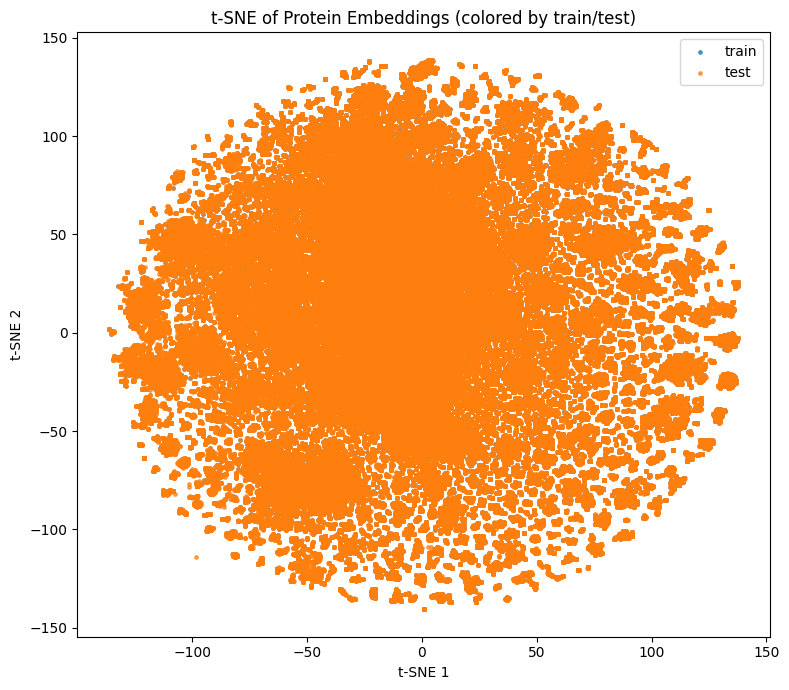

In [11]:
plt.figure(figsize=(8,7))

for split, color in [("train","tab:blue"), ("test","tab:orange")]:
    mask = df_all["split"] == split
    plt.scatter(
        df_all.loc[mask, "TSNE1"],
        df_all.loc[mask, "TSNE2"],
        s=6,
        alpha=0.7,
        label=split,
        c=color
    )

plt.legend()
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of Protein Embeddings (colored by train/test)")
plt.tight_layout()
plt.show()
